In [121]:
import pandas as pd
import pandas
from os import walk
import re
import os
from os import listdir
from os.path import join
import matplotlib.pyplot as plt
import datetime
import numpy as np

import nupic
from nupic.algorithms import anomaly_likelihood
from nupic.frameworks.opf.common_models.cluster_params import getScalarMetricWithTimeOfDayAnomalyParams
from nupic.frameworks.opf.model_factory import ModelFactory
from nab.detectors.base import AnomalyDetector
from nab.util import (absoluteFilePaths, createPath)
#from nupic.data.record_stream import RecordStreamIface


In [114]:
#Data Object class to read and transform csv file into Data Object 
class DataFile(object):
  """
  Class for storing and manipulating a single datafile.
  Data is stored in pandas.DataFrame
  """

  def __init__(self, srcPath):
    """
    @param srcPath (string)   Filename of datafile to read.
    """
    self.srcPath = srcPath

    self.fileName = os.path.split(srcPath)[1]

    self.data = pandas.io.parsers.read_csv(self.srcPath,
                                           header=0, parse_dates=[0])


  def write(self, newPath=None):
    """Write datafile to self.srcPath or newPath if given.

    @param newPath (string)   Path to write datafile to. If path is not given,
                              write to source path
    """

    path = newPath if newPath else self.srcPath
    self.data.to_csv(path, index=False)


  def modifyData(self, columnName, data=None, write=False):
    """Add columnName to datafile if data is given otherwise remove
    columnName.

    @param columnName (string)          Name of the column in the datafile to
                                        either add or remove.

    @param data       (pandas.Series)   Column data to be added to datafile.
                                        Data length should be as long as the
                                        length of other columns.

    @param write      (boolean) Flag to choose whether to write modifications to
                                source path.
    """
    if isinstance(data, pandas.Series):
      self.data[columnName] = data
    else:
      if columnName in self.data:
        del self.data[columnName]

    if write:
      self.write()


  def getTimestampRange(self, t1, t2):
    """Given timestamp range, get all records that are within that range.

    @param t1   (int)   Starting timestamp.

    @param t2   (int)   Ending timestamp.

    @return     (list)  Timestamp and value for each time stamp within the
                        timestamp range.
    """
    tmp = self.data[self.data["timestamp"] >= t1]
    ans = tmp[tmp["timestamp"] <= t2]["timestamp"].tolist()
    return ans


  def __str__(self):
    ans = ""
    ans += "path:                %s\n" % self.srcPath
    ans += "file name:           %s\n"% self.fileName
    ans += "data size:         ", self.data.shape()
    ans += "sample line: %s\n" % ", ".join(self.data[0])
    return ans

In [115]:
# Fraction outside of the range of values seen so far that will be considered
# a spatial anomaly regardless of the anomaly likelihood calculation. This
# accounts for the human labelling bias for spatial values larger than what
# has been seen so far.
SPATIAL_TOLERANCE = 0.05


class NumentaDetector(AnomalyDetector):
    #This detector uses an HTM based anomaly detection technique.#
    def __init__(self, *args, **kwargs):
        super(NumentaDetector, self).__init__(*args, **kwargs)
        
        self.model = None
        self.sensorParams = None
        self.anomalyLikelihood = None
        # Keep track of value range for spatial anomaly detection
        self.minVal = None
        self.maxVal = None

    # Set this to False if you want to get results based on raw scores
    # without using AnomalyLikelihood. This will give worse results, but
    # useful for checking the efficacy of AnomalyLikelihood. You will need
    # to re-optimize the thresholds when running with this setting.
        self.useLikelihood = True
  
    def getAdditionalHeaders(self):
        """Returns a list of strings."""
        return ["raw_score"]


    def handleRecord(self, inputData):
        """Returns a tuple (anomalyScore, rawScore).
        Internally to NuPIC "anomalyScore" corresponds to "likelihood_score"
        and "rawScore" corresponds to "anomaly_score". Sorry about that.
        """
        # Send it to Numenta detector and get back the results
        result = self.model.run(inputData)
        # Get the value
        value = inputData["value"]

        # Retrieve the anomaly score and write it to a file
        rawScore = result.inferences["anomalyScore"]

        # Update min/max values and check if there is a spatial anomaly
        spatialAnomaly = False
        if self.minVal != self.maxVal:
            tolerance = (self.maxVal - self.minVal) * SPATIAL_TOLERANCE
            maxExpected = self.maxVal + tolerance
            minExpected = self.minVal - tolerance
            if value > maxExpected or value < minExpected:
                spatialAnomaly = True
        if self.maxVal is None or value > self.maxVal:
            self.maxVal = value
        if self.minVal is None or value < self.minVal:
            self.minVal = value

        if self.useLikelihood:
            # Compute log(anomaly likelihood)
            anomalyScore = self.anomalyLikelihood.anomalyProbability(
                inputData["value"], rawScore, inputData["timestamp"])
            logScore = self.anomalyLikelihood.computeLogLikelihood(anomalyScore)
            finalScore = logScore
        else:
            finalScore = rawScore

        if spatialAnomaly:
            finalScore = 1.0

        return (finalScore, rawScore)


    def initialize(self):
        #How to create the HTM model, you know basicaly the min and max
        #Get config params, setting the RDSE resolution
        self.inputMin=float(self.inputMin)
        self.inputMax=float(self.inputMax)
        
        rangePadding = abs(self.inputMax - self.inputMin) * 0.2

        #best htm parameters for anomaly detection(Timestamp,value)
        #best practise parameters
        modelParams = getScalarMetricWithTimeOfDayAnomalyParams(
            metricData=[0],
            minVal=self.inputMin-rangePadding,
            maxVal=self.inputMax+rangePadding,
            minResolution=0.001,
            tmImplementation = "cpp"
        )["modelConfig"]

        self._setupEncoderParams(
            modelParams["modelParams"]["sensorParams"]["encoders"])
    
        #create your HTM model with parameters and given data
        self.model = ModelFactory.create(modelParams)
    
        #OPF for prediction, not used for anomaly detection
        self.model.enableInference({"predictedField": "value"})

        if self.useLikelihood:
            # Initialize the anomaly likelihood object
            numentaLearningPeriod = int(math.floor(self.probationaryPeriod / 2.0))
            self.anomalyLikelihood = anomaly_likelihood.AnomalyLikelihood(
                learningPeriod=numentaLearningPeriod,
                estimationSamples=self.probationaryPeriod-numentaLearningPeriod,
                reestimationPeriod=100
            )

        #setup encoder(expect "timestamp" and "value" as headers)
    def _setupEncoderParams(self, encoderParams):
        # The encoder must expect the NAB-specific datafile headers
        encoderParams["timestamp_dayOfWeek"] = encoderParams.pop("c0_dayOfWeek")
        encoderParams["timestamp_timeOfDay"] = encoderParams.pop("c0_timeOfDay")
        encoderParams["timestamp_timeOfDay"]["fieldname"] = "timestamp"
        encoderParams["timestamp_timeOfDay"]["name"] = "timestamp"
        encoderParams["timestamp_weekend"] = encoderParams.pop("c0_weekend")
        encoderParams["value"] = encoderParams.pop("c1")
        encoderParams["value"]["fieldname"] = "value"
        encoderParams["value"]["name"] = "value"

        self.sensorParams = encoderParams["value"]

C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\artificialNoAnomaly\art_daily_no_noise.csv


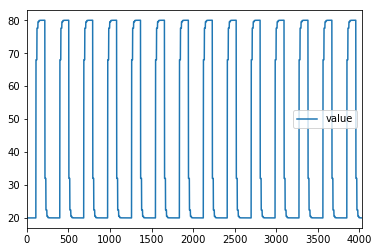

            timestamp  value
0 2014-04-01 00:00:00   20.0
1 2014-04-01 00:05:00   20.0
2 2014-04-01 00:10:00   20.0
3 2014-04-01 00:15:00   20.0
4 2014-04-01 00:20:00   20.0
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\artificialNoAnomaly\art_daily_perfect_square_wave.csv


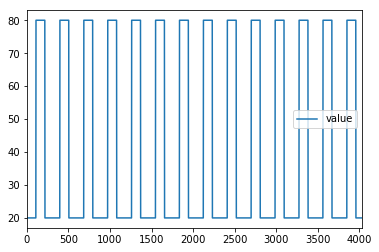

            timestamp  value
0 2014-04-01 00:00:00   20.0
1 2014-04-01 00:05:00   20.0
2 2014-04-01 00:10:00   20.0
3 2014-04-01 00:15:00   20.0
4 2014-04-01 00:20:00   20.0
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\artificialNoAnomaly\art_daily_small_noise.csv


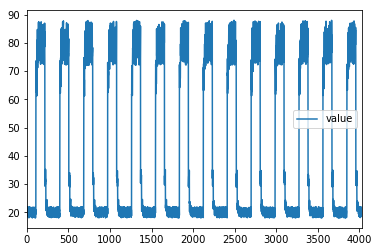

            timestamp      value
0 2014-04-01 00:00:00  18.324919
1 2014-04-01 00:05:00  21.970327
2 2014-04-01 00:10:00  18.624806
3 2014-04-01 00:15:00  21.953684
4 2014-04-01 00:20:00  21.909120
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\artificialNoAnomaly\art_flatline.csv


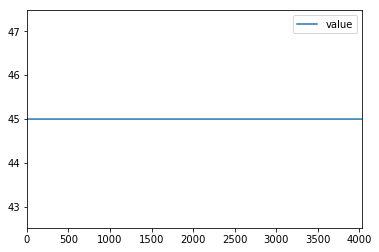

            timestamp  value
0 2014-04-01 00:00:00   45.0
1 2014-04-01 00:05:00   45.0
2 2014-04-01 00:10:00   45.0
3 2014-04-01 00:15:00   45.0
4 2014-04-01 00:20:00   45.0
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\artificialNoAnomaly\art_noisy.csv


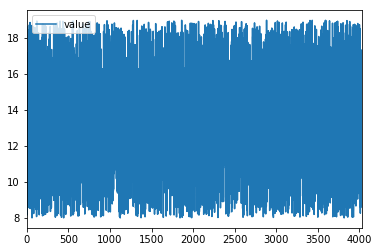

            timestamp      value
0 2014-04-01 00:00:00  18.622185
1 2014-04-01 00:05:00   8.163417
2 2014-04-01 00:10:00  13.292383
3 2014-04-01 00:15:00  11.667046
4 2014-04-01 00:20:00  12.940358
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\artificialWithAnomaly\art_daily_flatmiddle.csv


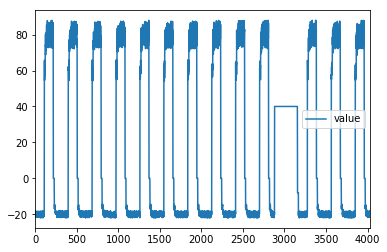

            timestamp      value
0 2014-04-01 00:00:00 -21.048383
1 2014-04-01 00:05:00 -20.295477
2 2014-04-01 00:10:00 -18.127229
3 2014-04-01 00:15:00 -20.171665
4 2014-04-01 00:20:00 -21.223762
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\artificialWithAnomaly\art_daily_jumpsdown.csv


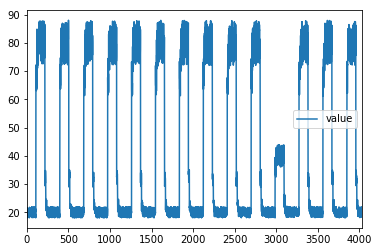

            timestamp      value
0 2014-04-01 00:00:00  18.090486
1 2014-04-01 00:05:00  20.359843
2 2014-04-01 00:10:00  21.105470
3 2014-04-01 00:15:00  21.151585
4 2014-04-01 00:20:00  18.137141
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\artificialWithAnomaly\art_daily_jumpsup.csv


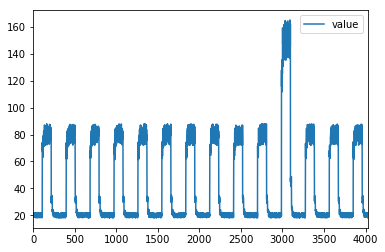

            timestamp      value
0 2014-04-01 00:00:00  19.761252
1 2014-04-01 00:05:00  20.500833
2 2014-04-01 00:10:00  19.961641
3 2014-04-01 00:15:00  21.490266
4 2014-04-01 00:20:00  20.187739
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\artificialWithAnomaly\art_daily_nojump.csv


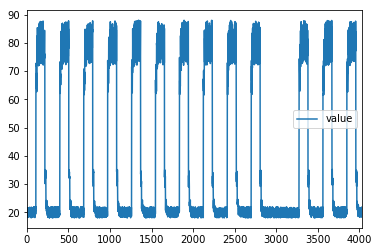

            timestamp      value
0 2014-04-01 00:00:00  21.598011
1 2014-04-01 00:05:00  19.321392
2 2014-04-01 00:10:00  21.399938
3 2014-04-01 00:15:00  18.373916
4 2014-04-01 00:20:00  18.167499
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\artificialWithAnomaly\art_increase_spike_density.csv


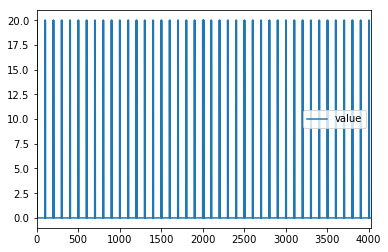

            timestamp  value
0 2014-04-01 00:00:00   20.0
1 2014-04-01 00:05:00    0.0
2 2014-04-01 00:10:00    0.0
3 2014-04-01 00:15:00    0.0
4 2014-04-01 00:20:00    0.0
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\artificialWithAnomaly\art_load_balancer_spikes.csv


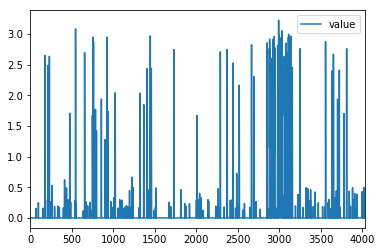

            timestamp  value
0 2014-04-01 00:00:00    0.0
1 2014-04-01 00:05:00    0.0
2 2014-04-01 00:10:00    0.0
3 2014-04-01 00:15:00    0.0
4 2014-04-01 00:20:00    0.0
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realAdExchange\exchange-2_cpc_results.csv


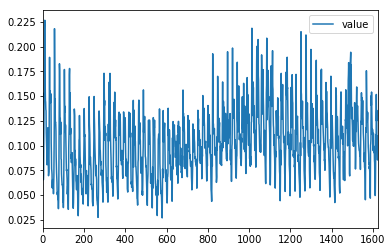

            timestamp     value
0 2011-07-01 00:00:01  0.081965
1 2011-07-01 01:00:01  0.098972
2 2011-07-01 02:00:01  0.065314
3 2011-07-01 03:00:01  0.070663
4 2011-07-01 04:00:01  0.102490
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realAdExchange\exchange-2_cpm_results.csv


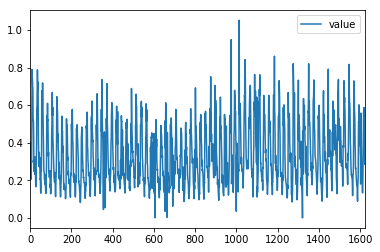

            timestamp     value
0 2011-07-01 00:00:01  0.401048
1 2011-07-01 01:00:01  0.392719
2 2011-07-01 02:00:01  0.309996
3 2011-07-01 03:00:01  0.212939
4 2011-07-01 04:00:01  0.205801
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realAdExchange\exchange-3_cpc_results.csv


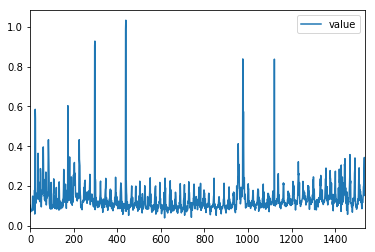

            timestamp     value
0 2011-07-01 00:15:01  0.102709
1 2011-07-01 01:15:01  0.068039
2 2011-07-01 02:15:01  0.077994
3 2011-07-01 03:15:01  0.077682
4 2011-07-01 04:15:01  0.077966
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realAdExchange\exchange-3_cpm_results.csv


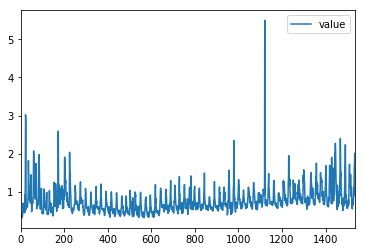

            timestamp     value
0 2011-07-01 00:15:01  0.405423
1 2011-07-01 01:15:01  0.433961
2 2011-07-01 02:15:01  0.389268
3 2011-07-01 03:15:01  0.368099
4 2011-07-01 04:15:01  0.365234
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realAdExchange\exchange-4_cpc_results.csv


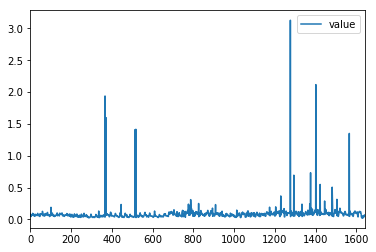

            timestamp     value
0 2011-07-01 00:15:01  0.091795
1 2011-07-01 01:15:01  0.074414
2 2011-07-01 02:15:01  0.056984
3 2011-07-01 03:15:01  0.071225
4 2011-07-01 04:15:01  0.045466
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realAdExchange\exchange-4_cpm_results.csv


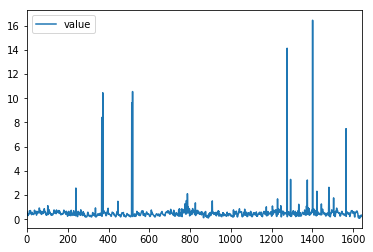

            timestamp     value
0 2011-07-01 00:15:01  0.618226
1 2011-07-01 01:15:01  0.506628
2 2011-07-01 02:15:01  0.399551
3 2011-07-01 03:15:01  0.482681
4 2011-07-01 04:15:01  0.306038
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realAWSCloudwatch\ec2_cpu_utilization_24ae8d.csv


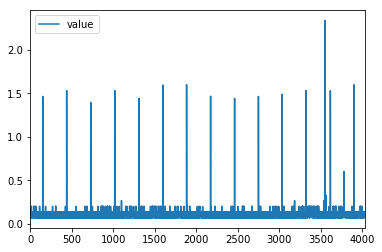

            timestamp  value
0 2014-02-14 14:30:00  0.132
1 2014-02-14 14:35:00  0.134
2 2014-02-14 14:40:00  0.134
3 2014-02-14 14:45:00  0.134
4 2014-02-14 14:50:00  0.134
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realAWSCloudwatch\ec2_cpu_utilization_53ea38.csv


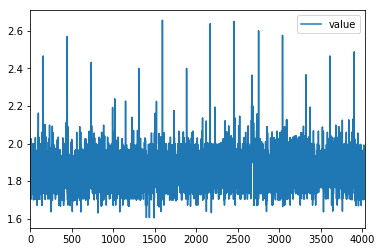

            timestamp  value
0 2014-02-14 14:30:00  1.732
1 2014-02-14 14:35:00  1.732
2 2014-02-14 14:40:00  1.960
3 2014-02-14 14:45:00  1.732
4 2014-02-14 14:50:00  1.706
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realAWSCloudwatch\ec2_cpu_utilization_5f5533.csv


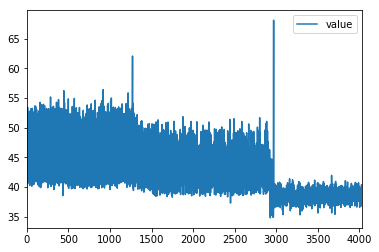

            timestamp   value
0 2014-02-14 14:27:00  51.846
1 2014-02-14 14:32:00  44.508
2 2014-02-14 14:37:00  41.244
3 2014-02-14 14:42:00  48.568
4 2014-02-14 14:47:00  46.714
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realAWSCloudwatch\ec2_cpu_utilization_77c1ca.csv


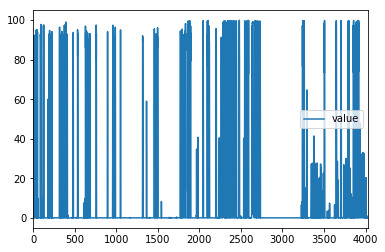

            timestamp  value
0 2014-04-02 14:25:00  0.068
1 2014-04-02 14:30:00  0.102
2 2014-04-02 14:35:00  0.100
3 2014-04-02 14:40:00  0.098
4 2014-04-02 14:45:00  0.102
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realAWSCloudwatch\ec2_cpu_utilization_825cc2.csv


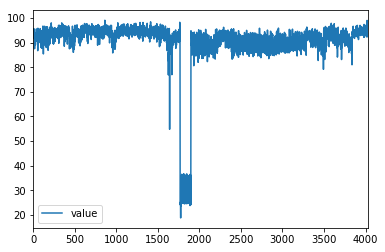

            timestamp   value
0 2014-04-10 00:04:00  91.958
1 2014-04-10 00:09:00  94.798
2 2014-04-10 00:14:00  92.208
3 2014-04-10 00:19:00  93.722
4 2014-04-10 00:24:00  93.042
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realAWSCloudwatch\ec2_cpu_utilization_ac20cd.csv


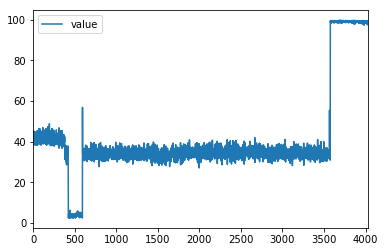

            timestamp   value
0 2014-04-02 14:29:00  42.652
1 2014-04-02 14:34:00  41.362
2 2014-04-02 14:39:00  43.408
3 2014-04-02 14:44:00  40.262
4 2014-04-02 14:49:00  40.328
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realAWSCloudwatch\ec2_cpu_utilization_c6585a.csv


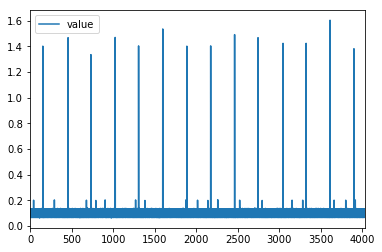

            timestamp  value
0 2014-04-02 14:29:00  0.066
1 2014-04-02 14:34:00  0.066
2 2014-04-02 14:39:00  0.068
3 2014-04-02 14:44:00  0.134
4 2014-04-02 14:49:00  0.066
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realAWSCloudwatch\ec2_cpu_utilization_fe7f93.csv


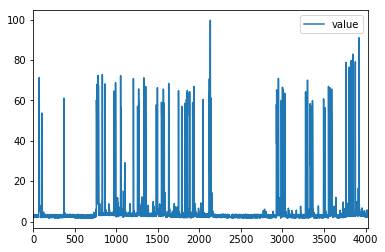

            timestamp  value
0 2014-02-14 14:27:00  2.296
1 2014-02-14 14:32:00  2.144
2 2014-02-14 14:37:00  2.274
3 2014-02-14 14:42:00  2.066
4 2014-02-14 14:47:00  2.350
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realAWSCloudwatch\ec2_disk_write_bytes_1ef3de.csv


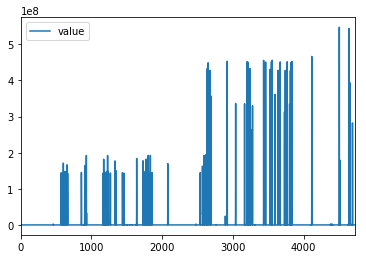

            timestamp  value
0 2014-03-01 17:34:00    0.0
1 2014-03-01 17:39:00    0.0
2 2014-03-01 17:44:00    0.0
3 2014-03-01 17:49:00    0.0
4 2014-03-01 17:54:00    0.0
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realAWSCloudwatch\ec2_disk_write_bytes_c0d644.csv


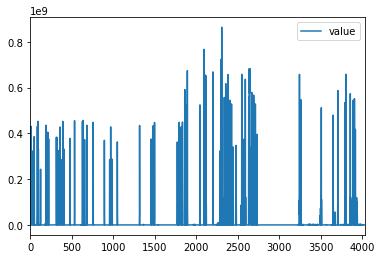

            timestamp  value
0 2014-04-02 14:25:00    0.0
1 2014-04-02 14:30:00    0.0
2 2014-04-02 14:35:00    0.0
3 2014-04-02 14:40:00    0.0
4 2014-04-02 14:45:00    0.0
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realAWSCloudwatch\ec2_network_in_257a54.csv


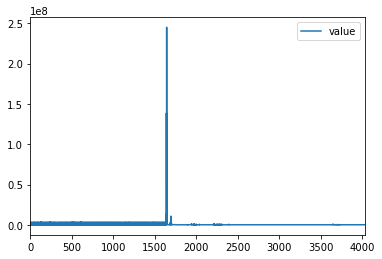

            timestamp      value
0 2014-04-10 00:04:00   251643.0
1 2014-04-10 00:09:00  3203510.0
2 2014-04-10 00:14:00   287397.0
3 2014-04-10 00:19:00   238944.0
4 2014-04-10 00:24:00   245880.0
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realAWSCloudwatch\ec2_network_in_5abac7.csv


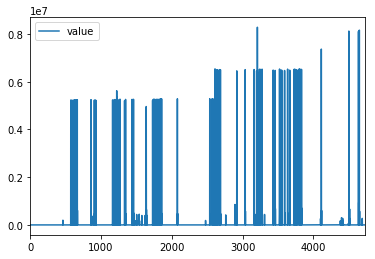

            timestamp  value
0 2014-03-01 17:36:00   42.0
1 2014-03-01 17:41:00   94.8
2 2014-03-01 17:46:00   42.0
3 2014-03-01 17:51:00   68.4
4 2014-03-01 17:56:00   68.4
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realAWSCloudwatch\elb_request_count_8c0756.csv


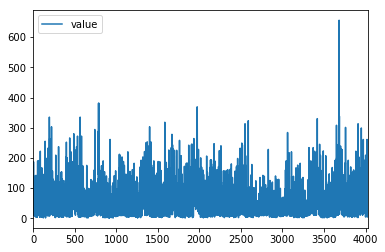

            timestamp  value
0 2014-04-10 00:04:00   94.0
1 2014-04-10 00:09:00   56.0
2 2014-04-10 00:14:00  187.0
3 2014-04-10 00:19:00   95.0
4 2014-04-10 00:24:00   51.0
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realAWSCloudwatch\grok_asg_anomaly.csv


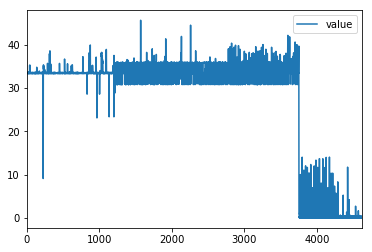

            timestamp    value
0 2014-01-16 00:00:00  33.5573
1 2014-01-16 00:05:00  33.4460
2 2014-01-16 00:10:00  33.4447
3 2014-01-16 00:15:00  33.3333
4 2014-01-16 00:20:00  33.4447
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realAWSCloudwatch\iio_us-east-1_i-a2eb1cd9_NetworkIn.csv


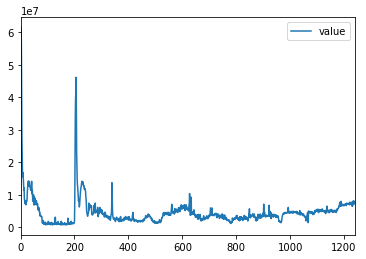

            timestamp       value
0 2013-10-09 16:25:00   9926554.0
1 2013-10-09 16:30:00  50745578.0
2 2013-10-09 16:35:00  61519397.0
3 2013-10-09 16:40:00  55996401.0
4 2013-10-09 16:45:00  40876988.0
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realAWSCloudwatch\rds_cpu_utilization_cc0c53.csv


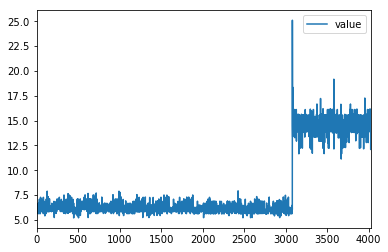

            timestamp  value
0 2014-02-14 14:30:00  6.456
1 2014-02-14 14:35:00  5.816
2 2014-02-14 14:40:00  6.268
3 2014-02-14 14:45:00  5.816
4 2014-02-14 14:50:00  5.862
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realAWSCloudwatch\rds_cpu_utilization_e47b3b.csv


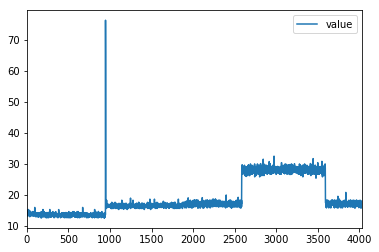

            timestamp   value
0 2014-04-10 00:02:00  14.012
1 2014-04-10 00:07:00  13.334
2 2014-04-10 00:12:00  15.000
3 2014-04-10 00:17:00  13.998
4 2014-04-10 00:22:00  14.332
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realKnownCause\ambient_temperature_system_failure.csv


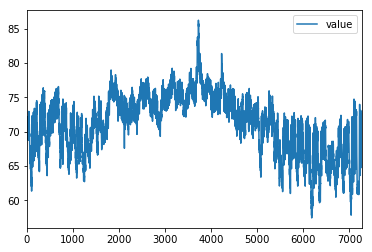

            timestamp      value
0 2013-07-04 00:00:00  69.880835
1 2013-07-04 01:00:00  71.220227
2 2013-07-04 02:00:00  70.877805
3 2013-07-04 03:00:00  68.959400
4 2013-07-04 04:00:00  69.283551
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realKnownCause\cpu_utilization_asg_misconfiguration.csv


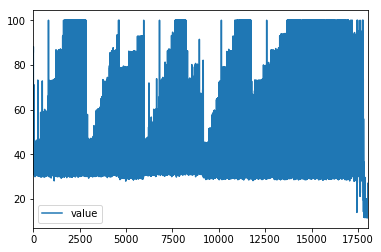

            timestamp   value
0 2014-05-14 01:14:00  85.835
1 2014-05-14 01:19:00  88.167
2 2014-05-14 01:24:00  44.595
3 2014-05-14 01:29:00  56.282
4 2014-05-14 01:34:00  36.534
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realKnownCause\ec2_request_latency_system_failure.csv


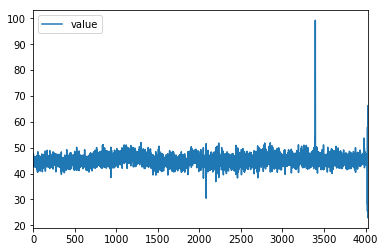

            timestamp   value
0 2014-03-07 03:41:00  45.868
1 2014-03-07 03:46:00  47.606
2 2014-03-07 03:51:00  42.580
3 2014-03-07 03:56:00  46.030
4 2014-03-07 04:01:00  44.992
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realKnownCause\machine_temperature_system_failure.csv


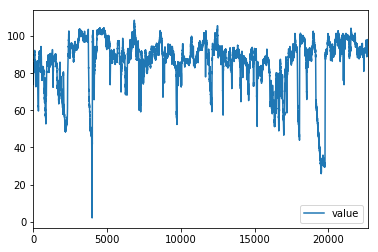

            timestamp      value
0 2013-12-02 21:15:00  73.967322
1 2013-12-02 21:20:00  74.935882
2 2013-12-02 21:25:00  76.124162
3 2013-12-02 21:30:00  78.140707
4 2013-12-02 21:35:00  79.329836
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realKnownCause\nyc_taxi.csv


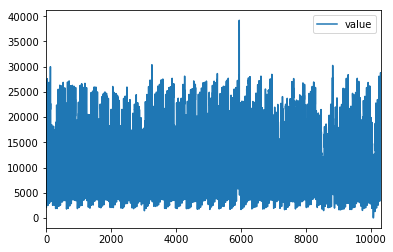

            timestamp  value
0 2014-07-01 00:00:00  10844
1 2014-07-01 00:30:00   8127
2 2014-07-01 01:00:00   6210
3 2014-07-01 01:30:00   4656
4 2014-07-01 02:00:00   3820
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realKnownCause\rogue_agent_key_hold.csv


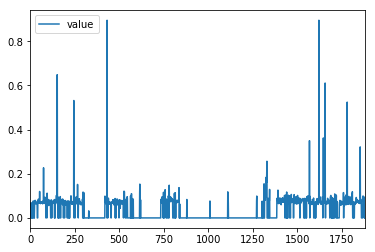

            timestamp     value
0 2014-07-06 20:10:00  0.064535
1 2014-07-06 20:15:00  0.064295
2 2014-07-06 20:20:00  0.063880
3 2014-07-06 20:25:00  0.065692
4 2014-07-06 20:35:00  0.056301
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realKnownCause\rogue_agent_key_updown.csv


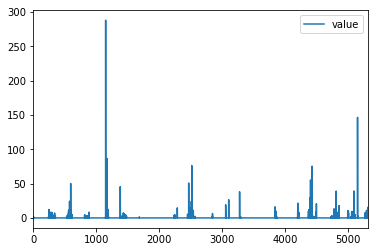

            timestamp     value
0 2014-07-06 20:10:00  1.047256
1 2014-07-06 20:15:00  1.848031
2 2014-07-06 20:20:00  1.297892
3 2014-07-06 20:25:00  1.593151
4 2014-07-06 20:35:00  0.000000
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realTraffic\occupancy_6005.csv


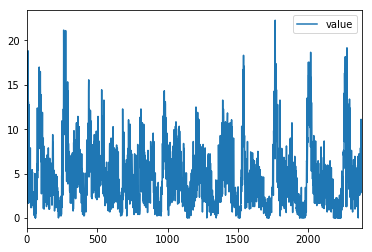

            timestamp  value
0 2015-09-01 13:45:00   3.06
1 2015-09-01 13:50:00   6.44
2 2015-09-01 13:55:00   5.17
3 2015-09-01 14:00:00   3.83
4 2015-09-01 14:05:00   4.50
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realTraffic\occupancy_t4013.csv


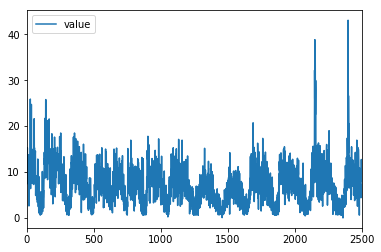

            timestamp  value
0 2015-09-01 11:30:00  13.56
1 2015-09-01 11:35:00   8.33
2 2015-09-01 11:40:00  11.78
3 2015-09-01 11:55:00  15.28
4 2015-09-01 12:00:00  10.06
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realTraffic\speed_6005.csv


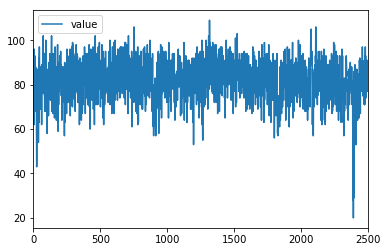

            timestamp  value
0 2015-08-31 18:22:00     90
1 2015-08-31 18:32:00     80
2 2015-08-31 18:57:00     84
3 2015-08-31 19:07:00     94
4 2015-08-31 19:12:00     90
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realTraffic\speed_7578.csv


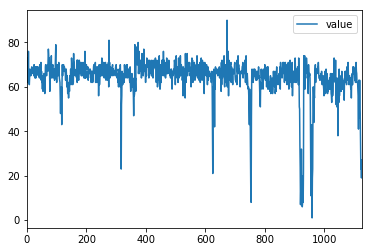

            timestamp  value
0 2015-09-08 11:39:00     73
1 2015-09-08 11:44:00     62
2 2015-09-08 11:59:00     66
3 2015-09-08 12:19:00     69
4 2015-09-08 12:24:00     65
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realTraffic\speed_t4013.csv


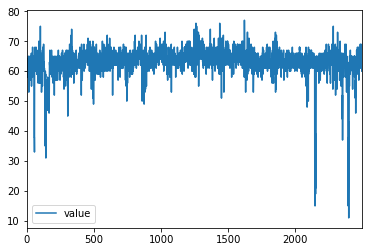

            timestamp  value
0 2015-09-01 11:25:00     58
1 2015-09-01 11:30:00     63
2 2015-09-01 11:35:00     63
3 2015-09-01 11:40:00     64
4 2015-09-01 11:55:00     58
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realTraffic\TravelTime_387.csv


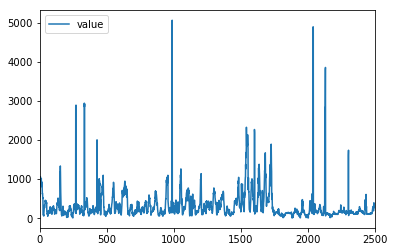

            timestamp  value
0 2015-07-10 14:24:00    564
1 2015-07-10 14:38:00    730
2 2015-07-10 14:48:00    770
3 2015-07-10 15:03:00    910
4 2015-07-10 15:22:00   1035
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realTraffic\TravelTime_451.csv


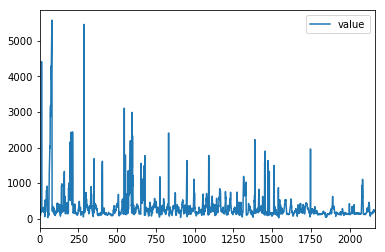

            timestamp  value
0 2015-07-28 11:56:00    248
1 2015-07-28 12:06:00    178
2 2015-07-28 12:25:00    155
3 2015-07-28 13:56:00    121
4 2015-07-28 14:06:00    103
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realTweets\Twitter_volume_AAPL.csv


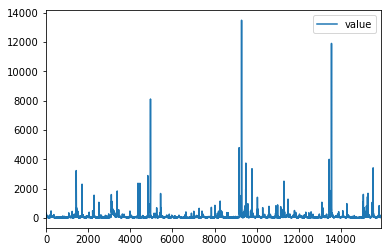

            timestamp  value
0 2015-02-26 21:42:53    104
1 2015-02-26 21:47:53    100
2 2015-02-26 21:52:53     99
3 2015-02-26 21:57:53    154
4 2015-02-26 22:02:53    120
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realTweets\Twitter_volume_AMZN.csv


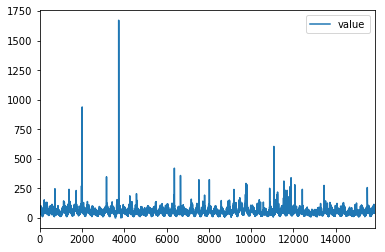

            timestamp  value
0 2015-02-26 21:42:53     57
1 2015-02-26 21:47:53     43
2 2015-02-26 21:52:53     55
3 2015-02-26 21:57:53     64
4 2015-02-26 22:02:53     93
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realTweets\Twitter_volume_CRM.csv


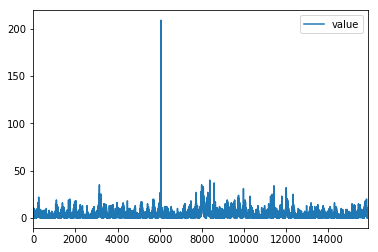

            timestamp  value
0 2015-02-26 21:42:53     11
1 2015-02-26 21:47:53     10
2 2015-02-26 21:52:53      3
3 2015-02-26 21:57:53      4
4 2015-02-26 22:02:53      9
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realTweets\Twitter_volume_CVS.csv


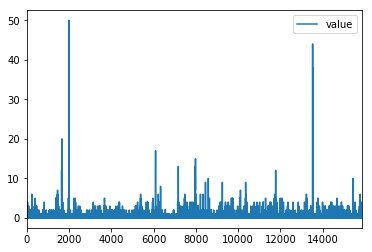

            timestamp  value
0 2015-02-26 21:42:53      0
1 2015-02-26 21:47:53      0
2 2015-02-26 21:52:53      0
3 2015-02-26 21:57:53      0
4 2015-02-26 22:02:53      0
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realTweets\Twitter_volume_FB.csv


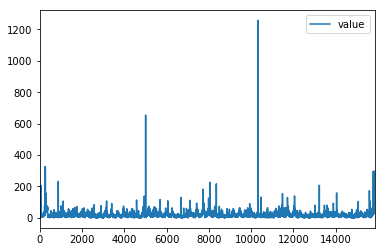

            timestamp  value
0 2015-02-26 21:42:53     53
1 2015-02-26 21:47:53     64
2 2015-02-26 21:52:53     49
3 2015-02-26 21:57:53     48
4 2015-02-26 22:02:53     22
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realTweets\Twitter_volume_GOOG.csv


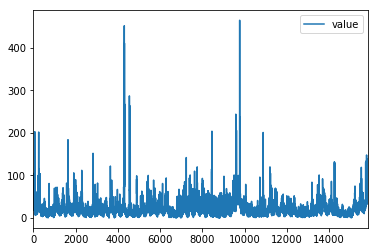

            timestamp  value
0 2015-02-26 21:42:53     35
1 2015-02-26 21:47:53     41
2 2015-02-26 21:52:53     32
3 2015-02-26 21:57:53     36
4 2015-02-26 22:02:53     32
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realTweets\Twitter_volume_IBM.csv


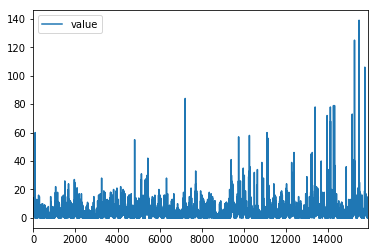

            timestamp  value
0 2015-02-26 21:42:53      7
1 2015-02-26 21:47:53      4
2 2015-02-26 21:52:53     14
3 2015-02-26 21:57:53      6
4 2015-02-26 22:02:53      1
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realTweets\Twitter_volume_KO.csv


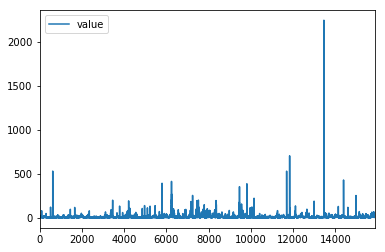

            timestamp  value
0 2015-02-26 21:42:53      8
1 2015-02-26 21:47:53      8
2 2015-02-26 21:52:53      5
3 2015-02-26 21:57:53     13
4 2015-02-26 22:02:53     22
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realTweets\Twitter_volume_PFE.csv


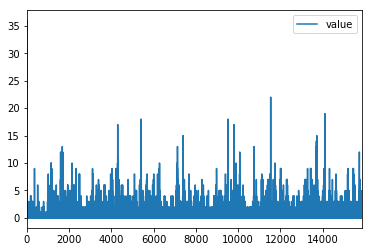

            timestamp  value
0 2015-02-26 21:42:53      3
1 2015-02-26 21:47:53      2
2 2015-02-26 21:52:53      2
3 2015-02-26 21:57:53     36
4 2015-02-26 22:02:53      8
C:\Users\RJO7ABT\Documents\Bosch-MT\Daten\NAB\realTweets\Twitter_volume_UPS.csv


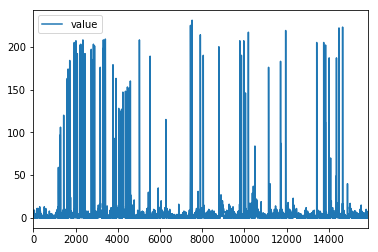

            timestamp  value
0 2015-02-26 21:42:53      2
1 2015-02-26 21:47:53      2
2 2015-02-26 21:52:53      4
3 2015-02-26 21:57:53      3
4 2015-02-26 22:02:53      5


In [123]:
path_nab = 'C:\\Users\\RJO7ABT\\Documents\\Bosch-MT\\Daten\\NAB\\'

folders = [d for d in listdir('C:\\Users\\RJO7ABT\\Documents\\Bosch-MT\\Daten\\NAB\\') if f.endswith('')]

for folder in folders:
    dir = path_nab + folder
    #print(dir)
    files = [f for f in listdir(dir) if f.endswith('.csv')]
    for file in files:
         csv_file = dir + "\\" + file
         df = pd.read_csv(csv_file)
         print(csv_file)
         df.plot()
         plt.show()
            
         #create data file object
         inputData = DataFile(csv_file)
         #anomaly detection
         ad = NumentaDetector(inputData, 0.5)
         ad.initialize()
         
